# 逻辑回归

## 加载数据

In [274]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [285]:
def add_intercept(x):
    """向数据集中添加全1的列
    参数: 二维数组x
    返回: 在第1列添加全1列的二维数组
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x

In [286]:
def load_dataset(csv_path, label_col='y'):
    """从一个csv文件中加载数据
    """
    # 验证label_col的参数
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col:{}(excepted {})'
                         .format(label_col, allowed_label_cols))
    #csv文件的头
    with open(csv_path, 'r') as scv_fh:
        headers = scv_fh.readline().strip().split(',')
    # 读取特征和标签,特征以x开头
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)
    print(x_cols, l_cols)
    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)
    inputs = add_intercept(inputs)
    return inputs, labels

In [288]:
# x_train, y_train = load_dataset('train.csv', label_col='y')
x_train, y_train = load_dataset('ds1_train.csv', label_col='y')
x_train[:5], y_train[:5] , x_train.shape, y_train.shape 

[0, 1] [2]


(array([[  1.        ,   2.91180854,  60.35961272],
        [  1.        ,   3.77474554, 344.1492843 ],
        [  1.        ,   2.61548828, 178.22208681],
        [  1.        ,   2.01369376,  15.25947155],
        [  1.        ,   2.75762504,  66.19417399]]),
 array([0., 0., 0., 0., 0.]),
 (800, 3),
 (800,))

## 绘制样本

In [289]:
def plot(x, y, theta=None, save_path=None, correction=1.0):
    plt.figure()
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    if theta is not None:
        margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
        margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
        x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
        x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
        plt.plot(x1, x2, c='red', linewidth=2)
        plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
        plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    if save_path is not None:
        plt.savefig(save_path)

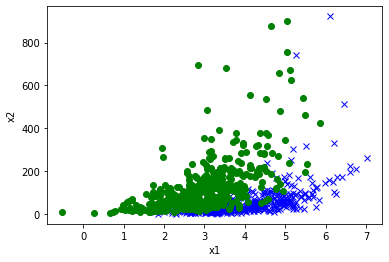

In [290]:
plot(x_train, y_train) 

## 线性回归用到的一些基本函数

In [291]:
def plot_loss(train_loss, val_loss=None):
    fig, ax = plt.subplots(figsize=(12,8))
    iters = len(train_loss)
    ax.plot(np.arange(iters), train_loss, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    if val_loss is not None:
        iters = len(val_loss)
        ax.plot(np.arange(iters), train_loss, 'b')
    plt.show()

## 一些常用的函数

# $$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$

In [281]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

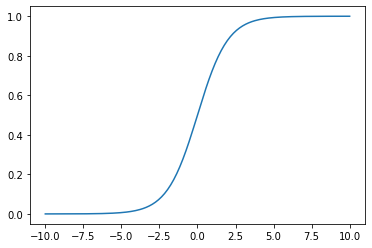

In [292]:
tmp = np.linspace(-10, 10, 200)
fig, ax = plt.subplots()
ax.plot(tmp, sigmoid(tmp))
plt.show()

# $${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$

In [293]:
def h(theta, x):
    return sigmoid(np.dot(x, theta)) 

loss function:
# $$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$$


In [248]:
def loss_function(theta, x, y):
    first = np.multiply(-y, np.log(h(theta, x)))
    second = np.multiply(1-y, np.log(1-h(theta, x)))
    return np.sum(first - second) / len(x)

Compute the gradient of $J(\theta)$:

\begin{align*}
\nabla_\theta J(\theta) & = - \frac{1}{m} \sum_{i = 1}^{m} y^{(i)} \frac{1}{h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) - (1 - y^{(i)}) \frac{1}{1 - h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) \\
                        & = - \frac{1}{m} \sum_{i = 1}^{m} \big( y^{(i)} - h_\theta (x^{(i)}) \big) x^{(i)}
\end{align*}

In [249]:
def gradient(theta, x, y):
    m, _ = x.shape
    return -1 / m * np.dot(x.T, (y - h(theta, x)))


In [250]:
# 预测,如果x^T theta >= 0是正样本
def predict(theta, x):
    return x @ theta >= 0

## 使用批量梯度下降的方法进行训练

In [253]:
def batch_grad_descent(x, y):
    alpha = 0.0001
    iters = 10000 
    theta = np.zeros(x_train.shape[1], dtype=x_train.dtype)
    cost = np.zeros(iters)
    for i in range(iters):
        theta = theta - alpha * gradient(theta, x, y)
        cost[i] = loss_function(theta, x, y)
    return theta, cost  

In [254]:
bgd_theta, bgd_loss = batch_grad_descent(x_train, y_train)

In [255]:
bgd_theta, loss_function(bgd_theta, x_train,y_train)

(array([ 0.02117602,  0.35147701, -0.01476841]), 0.5173710441615023)

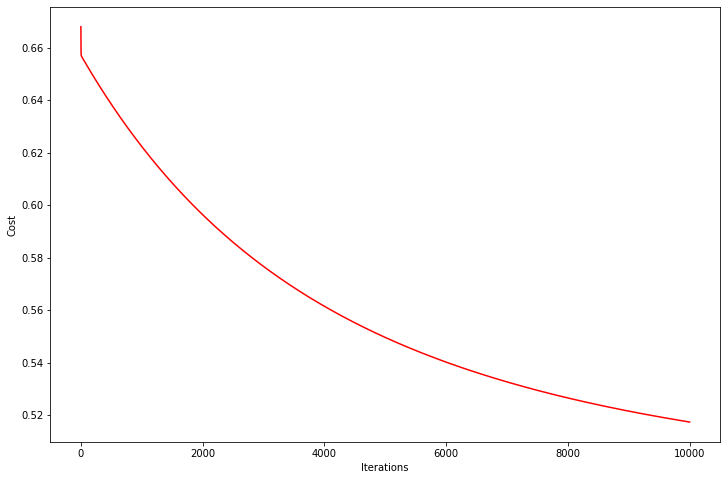

In [256]:
plot_loss(bgd_loss)

Theta is:  [ 0.02117602  0.35147701 -0.01476841]
The accuracy on training set is:  0.75875


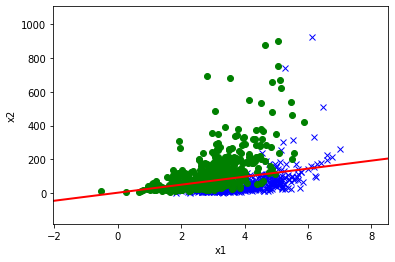

In [257]:
plot(x_train, y_train, theta=bgd_theta)
print("Theta is: ",bgd_theta)
print("The accuracy on training set is: ", np.mean(predict(bgd_theta,x_train) == y_train))

## 牛顿法

![image-20220422121457664](https://s2.loli.net/2022/04/22/9VEpigcdy56HWRN.png)

![image-20220422121534298](https://s2.loli.net/2022/04/22/zmjitORI5FV3SYx.png)


![image-20220422121624601](https://s2.loli.net/2022/04/22/9iLNyl2k8v4p1RB.png)


Recall the average empirical loss for logistic regression:

$$J(\theta) = - \frac{1}{m} \sum_{i = 1}^{m} y^{(i)} \log \big( h_\theta (x^{(i)}) \big) + (1 - y^{(i)}) \log \big( 1 - h_\theta (x^{(i)}) \big)$$,

where $y^{(i)} \in \{ 0, 1 \}, h_\theta (x) = g(\theta^T x)$ and $g(z) = 1 / (1 + e^{-z})$.



Compute the gradient of $J(\theta)$:

\begin{align*}
\nabla_\theta J(\theta) & = - \frac{1}{m} \sum_{i = 1}^{m} y^{(i)} \frac{1}{h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) - (1 - y^{(i)}) \frac{1}{1 - h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) \\
                        & = - \frac{1}{m} \sum_{i = 1}^{m} \big( y^{(i)} - h_\theta (x^{(i)}) \big) x^{(i)}
\end{align*}



Then, the Hessian of $J(\theta)$ is:

$$H = \nabla_\theta^2 J(\theta) = \frac{1}{m} \sum_{i = 1}^{m}  h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) x^{(i)} (x^{(i)})^T$$



In [259]:
def hessian(theta, x):
    m, _ = x.shape       
    h_theta_x = np.reshape(h(theta, x), (-1, 1))
    return 1 / m * np.dot(x.T, h_theta_x * ( 1 - h_theta_x) * x)
 

In [260]:
def next_theta(theta, x, y):
    return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

In [261]:
def fit(x, y):
    m, n = x.shape
    theta = np.zeros(n)
    eps = 1e-5
    old_theta = theta
    new_theta = next_theta(theta, x , y)
    loss = [loss_function(old_theta, x, y)] 
    while np.linalg.norm(new_theta - old_theta, 1) >= eps:
        old_theta = new_theta
        loss.append(loss_function(old_theta, x, y))
        new_theta = next_theta(old_theta, x_train, y_train)
    return new_theta, loss

In [262]:
newton_theta, newton_loss = fit(x_train,y_train)


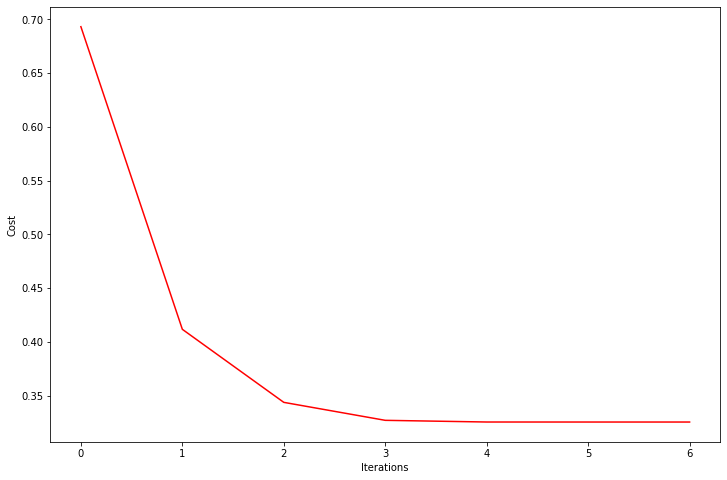

(array([-6.26018491,  2.47707251, -0.0299125 ]), 0.3255719112349646)

In [268]:
plot_loss(newton_loss)
newton_theta, loss_function(newton_theta, x_train, y_train)

Theta is:  [ 0.02117602  0.35147701 -0.01476841]
The accuracy on training set is:  0.8825


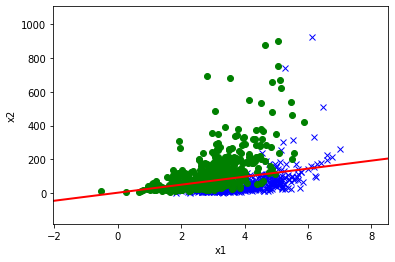

In [269]:
plot(x_train, y_train, theta=bgd_theta)
print("Theta is: ",bgd_theta)
print("The accuracy on training set is: ", np.mean(predict(newton_theta,x_train) ==  y_train))
    

In [270]:
x_valid, y_valid = load_dataset('ds1_valid.csv', label_col='y')
x_valid[:5],y_valid[: 5], x_valid.shape, y_valid.shape

[0, 1] [2]


(array([[  1.        ,   2.1773955 ,  78.63007649],
        [  1.        ,   3.95213116, 123.5415734 ],
        [  1.        ,   3.35117646,  47.75251718],
        [  1.        ,   2.07493367,  26.99772989],
        [  1.        ,   3.57977541, 226.70377922]]),
 array([0., 0., 0., 0., 0.]),
 (100, 3),
 (100,))

The accuracy on validation set is:  0.9


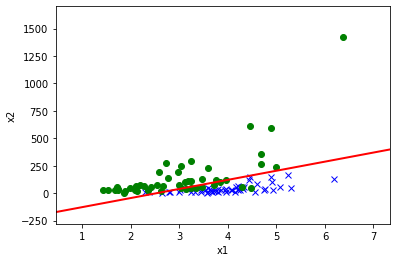

In [271]:
plot(x_valid, y_valid, newton_theta)
print("The accuracy on validation set is: ", np.mean(predict(newton_theta,x_valid) == y_valid))

The accuracy on validation set is:  0.74


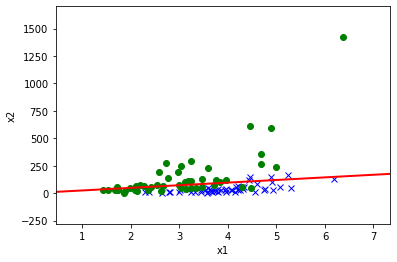

In [273]:
plot(x_valid, y_valid, bgd_theta)
print("The accuracy on validation set is: ", np.mean(predict(bgd_theta,x_valid) == y_valid))